# Part 3 - Logistic Regression
Predicting the outcome of a shot given its features

`Logistic regression` is used when the targeted outcome is classified into two outcomes. But as linear regression only predict 0 or 1, we can with logistic regression we get a probability between 0 and 1 which is useful for the probability of a goal.

### Prepare data and all things for predictions

In [1]:
#import libearies
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#the url´s where the data is stored
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

In [5]:
#create our parse data function
def parse_data(competition_id, season_id):
    matches = requests.get(url = comp_url.format(competition_id, season_id)).json()
    match_ids = [match["match_id"] for match in matches]
    
    all_events = []
    for match_id in match_ids:
        
        events = requests.get(url = match_url.format(match_id)).json()
        
        shots = [x for x in events if x["type"]["name"] == "Shot"]
        for shot in shots:
            attributes = {
                "x": shot["location"][0],
                "y": shot["location"][1],
                "minute": shot["minute"],
                "outcome": shot["shot"]["outcome"]["name"],
                "head": 1 if shot["shot"]["body_part"]["name"] == "Head" else 0,
                "phase": shot["shot"]["type"]["name"],
                "outcome": 1 if shot["shot"]["outcome"]["name"] == "Goal" else 0,
                "statsbomb_xg": shot["shot"]["statsbomb_xg"]
            }
            all_events.append(attributes)
        
    return pd.DataFrame(all_events)

This time we have added additional data to the `parse_data` function:
- x - the x-coordinate of the shot ranges from 0 to 120
- y - the y-coordinate of the shot ranges from 0 to 80
- minute - what minute the shot were taken
- head - if the shot was attempted with the head
- phase - what phase of play did the shot come from
- outcome - did the shot result in a goal
- statsbomb_xg - for comparison purposes at the end of the notebook

**Note:** _We will not use the xG as a feature to our model because the xG is already a really prediction of the outcome of if the shot resulted in a goal._

**Why these features**:
- x and y
- minute
- head
- phase
- outcome
- statsbomb_xg

In [6]:
#load data from 2018 World Cup
competition_id = 43
season_id = 3
df = parse_data(43, 3)

In [7]:
df.head()

,x,y,minute,outcome,head,phase,statsbomb_xg
0,115.0,34.0,0,1,0,Open Play,0.094462
1,112.0,36.0,3,1,0,Open Play,0.236519
2,101.0,55.0,11,0,0,Free Kick,0.053822
3,103.0,24.0,18,0,0,Open Play,0.029023
4,96.0,37.0,22,0,0,Open Play,0.041431


#### We can now create some measurements around the shots, more precise `distance_to_goal` and `goal_angle`.

In [18]:
#function that calculates the distance to the center of the goal
def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))

In [19]:
#function that calculates the angle within the shot is taken
def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

We will now add these columns to our dataframe.

We will use the technique broadcasting, which is efficient n large datasets. We are also using the lambda to avoid loopig through our pandas df.

In [20]:
df['distance_to_goal'] = df.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
df['goal_angle'] = df.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)

In [21]:
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]

## Start prediction and logistic regression

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [27]:
features = shots[['distance_to_goal', 'goal_angle', 'head']]
labels = shots['outcome']

fit = model.fit(features, labels)

In [28]:
predictions = model.predict_proba(features)[:, 1]

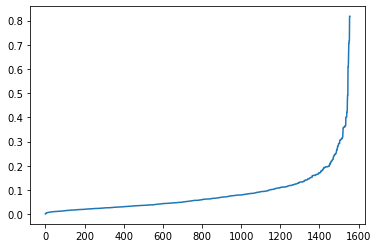

In [29]:
plt.plot(sorted(predictions))
plt.show()

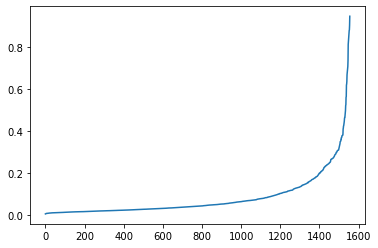

In [30]:
plt.plot(sorted(shots['statsbomb_xg']))
plt.show()